In [19]:
SCITSR_PATH = '/Users/admin/Developer/table-recognition/data/SciTSR-partition'
MODEL_WEIGHT = '/Users/admin/Developer/table-recognition/pret-models/split0.pth'

In [20]:
import numpy as np
from tqdm import tqdm
import os
import pickle

from data_utils.utils import *
from merge.heuristics import *
from adjacency_relation.relation import *
from dataset.dataset import ImageDataset
from modules.split_modules import SplitModel

In [21]:
# LOAD MODEL
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SplitModel(3)
model = torch.nn.DataParallel(model).to(device)

if device == 'cuda':
    model.load_state_dict(torch.load(MODEL_WEIGHT))
else:
    model.load_state_dict(torch.load(MODEL_WEIGHT, map_location=torch.device('cpu')))

device

'cpu'

In [22]:
SUBSET = 'train'
print(f'Loading data for the "{SUBSET}" subset')

# Load images
img_dir = os.path.join(SCITSR_PATH, SUBSET, 'img')
img_paths = [os.path.join(img_dir, p) for p in os.listdir(img_dir)]
print(f'- Got {len(img_paths)} images')

# Load Merge labels
merge_json = os.path.join(SCITSR_PATH, SUBSET, 'label', 'merge_label.json')
merge_labels = load_json(merge_json)
print(f"- Loaded {len(merge_labels)} labels for Merge module")

# Load Text posisions
chunk_json = os.path.join(SCITSR_PATH, SUBSET, 'label', 'chunk_label.json')
chunk_labels = load_json(chunk_json)
print(f"- Loaded texts positions for {len(chunk_labels)} images")

# Load dataset
split_json = os.path.join(SCITSR_PATH, SUBSET, 'label', 'split_label.json')
split_labels = load_json(split_json)
dataset = ImageDataset(img_dir, split_labels, 8, scale=1, min_width=10, returns_image_name=True)
print(f'- Loaded dataset with {len(dataset)} examples')

Loading data for the "train" subset
- Got 10000 images
- Loaded 10000 labels for Merge module
- Loaded texts positions for 10000 images
- Loaded dataset with 10000 examples


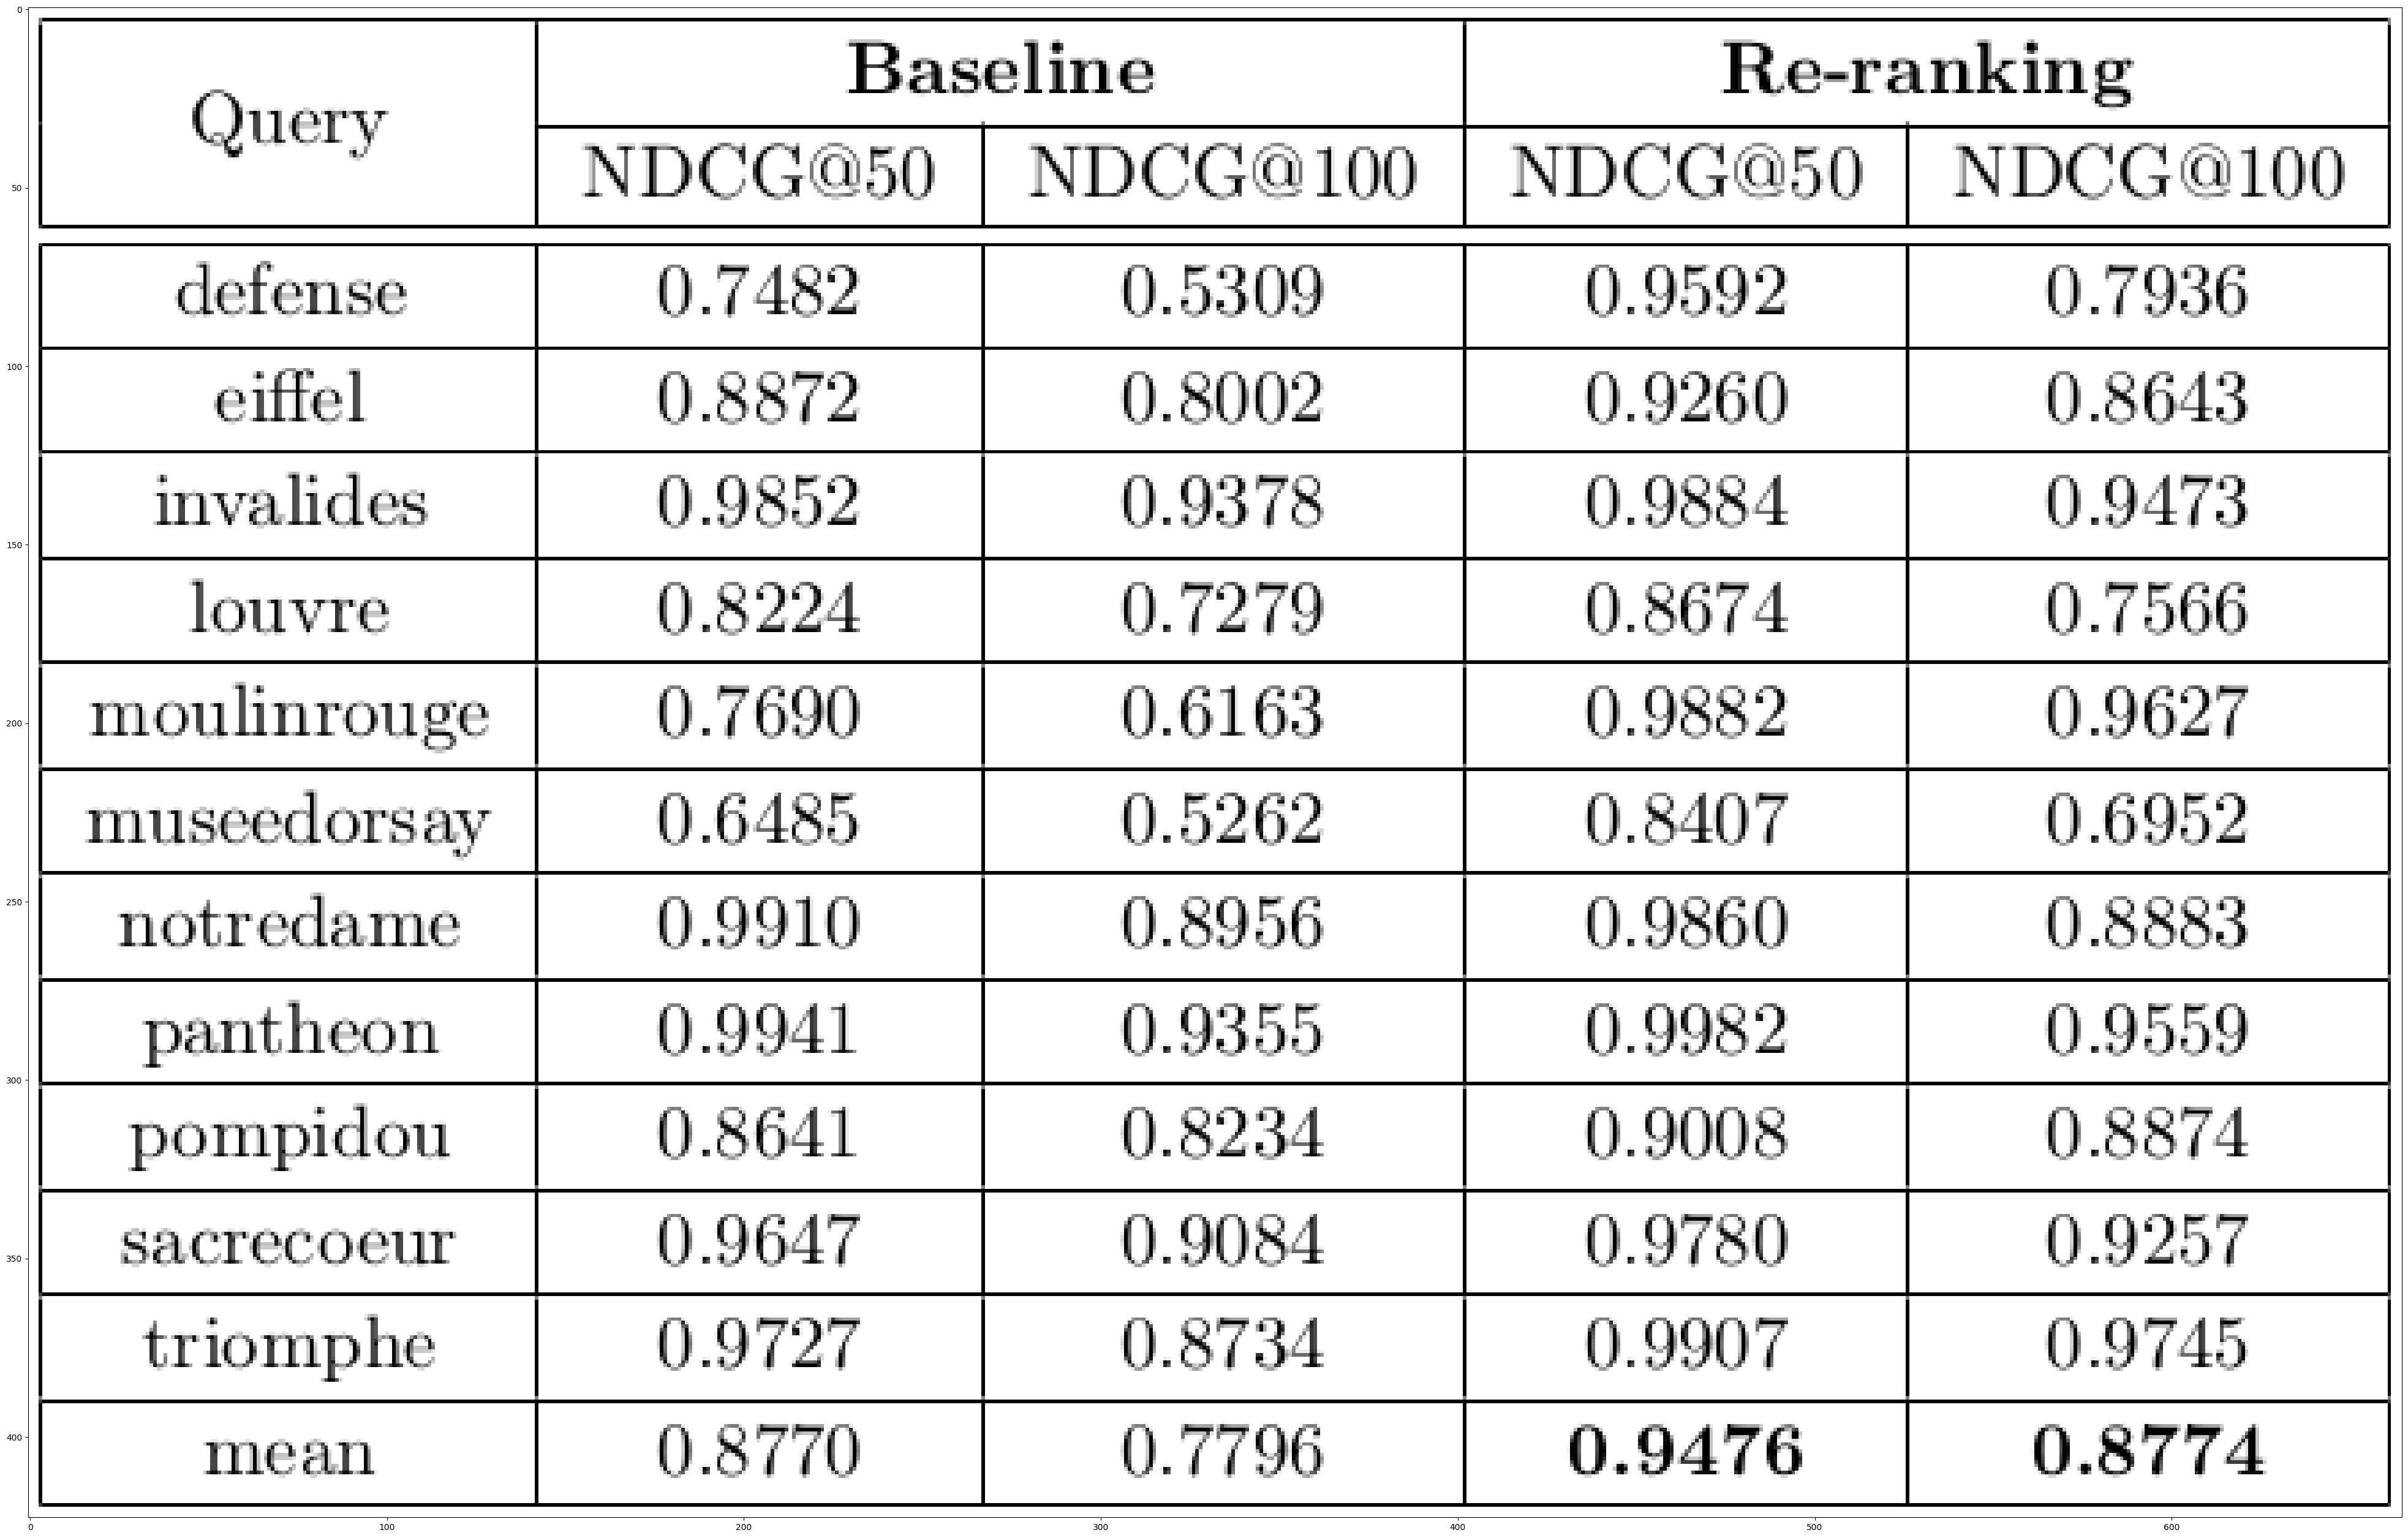

In [23]:
IDX = 12
sample_img = load_image(img_paths[IDX])
img_name = path2name(img_paths[IDX])

# img_name = '1303.1872v1.1'
# sample_img = load_image(os.path.join(img_dir, img_name + '.png'))

view_imgs([sample_img])

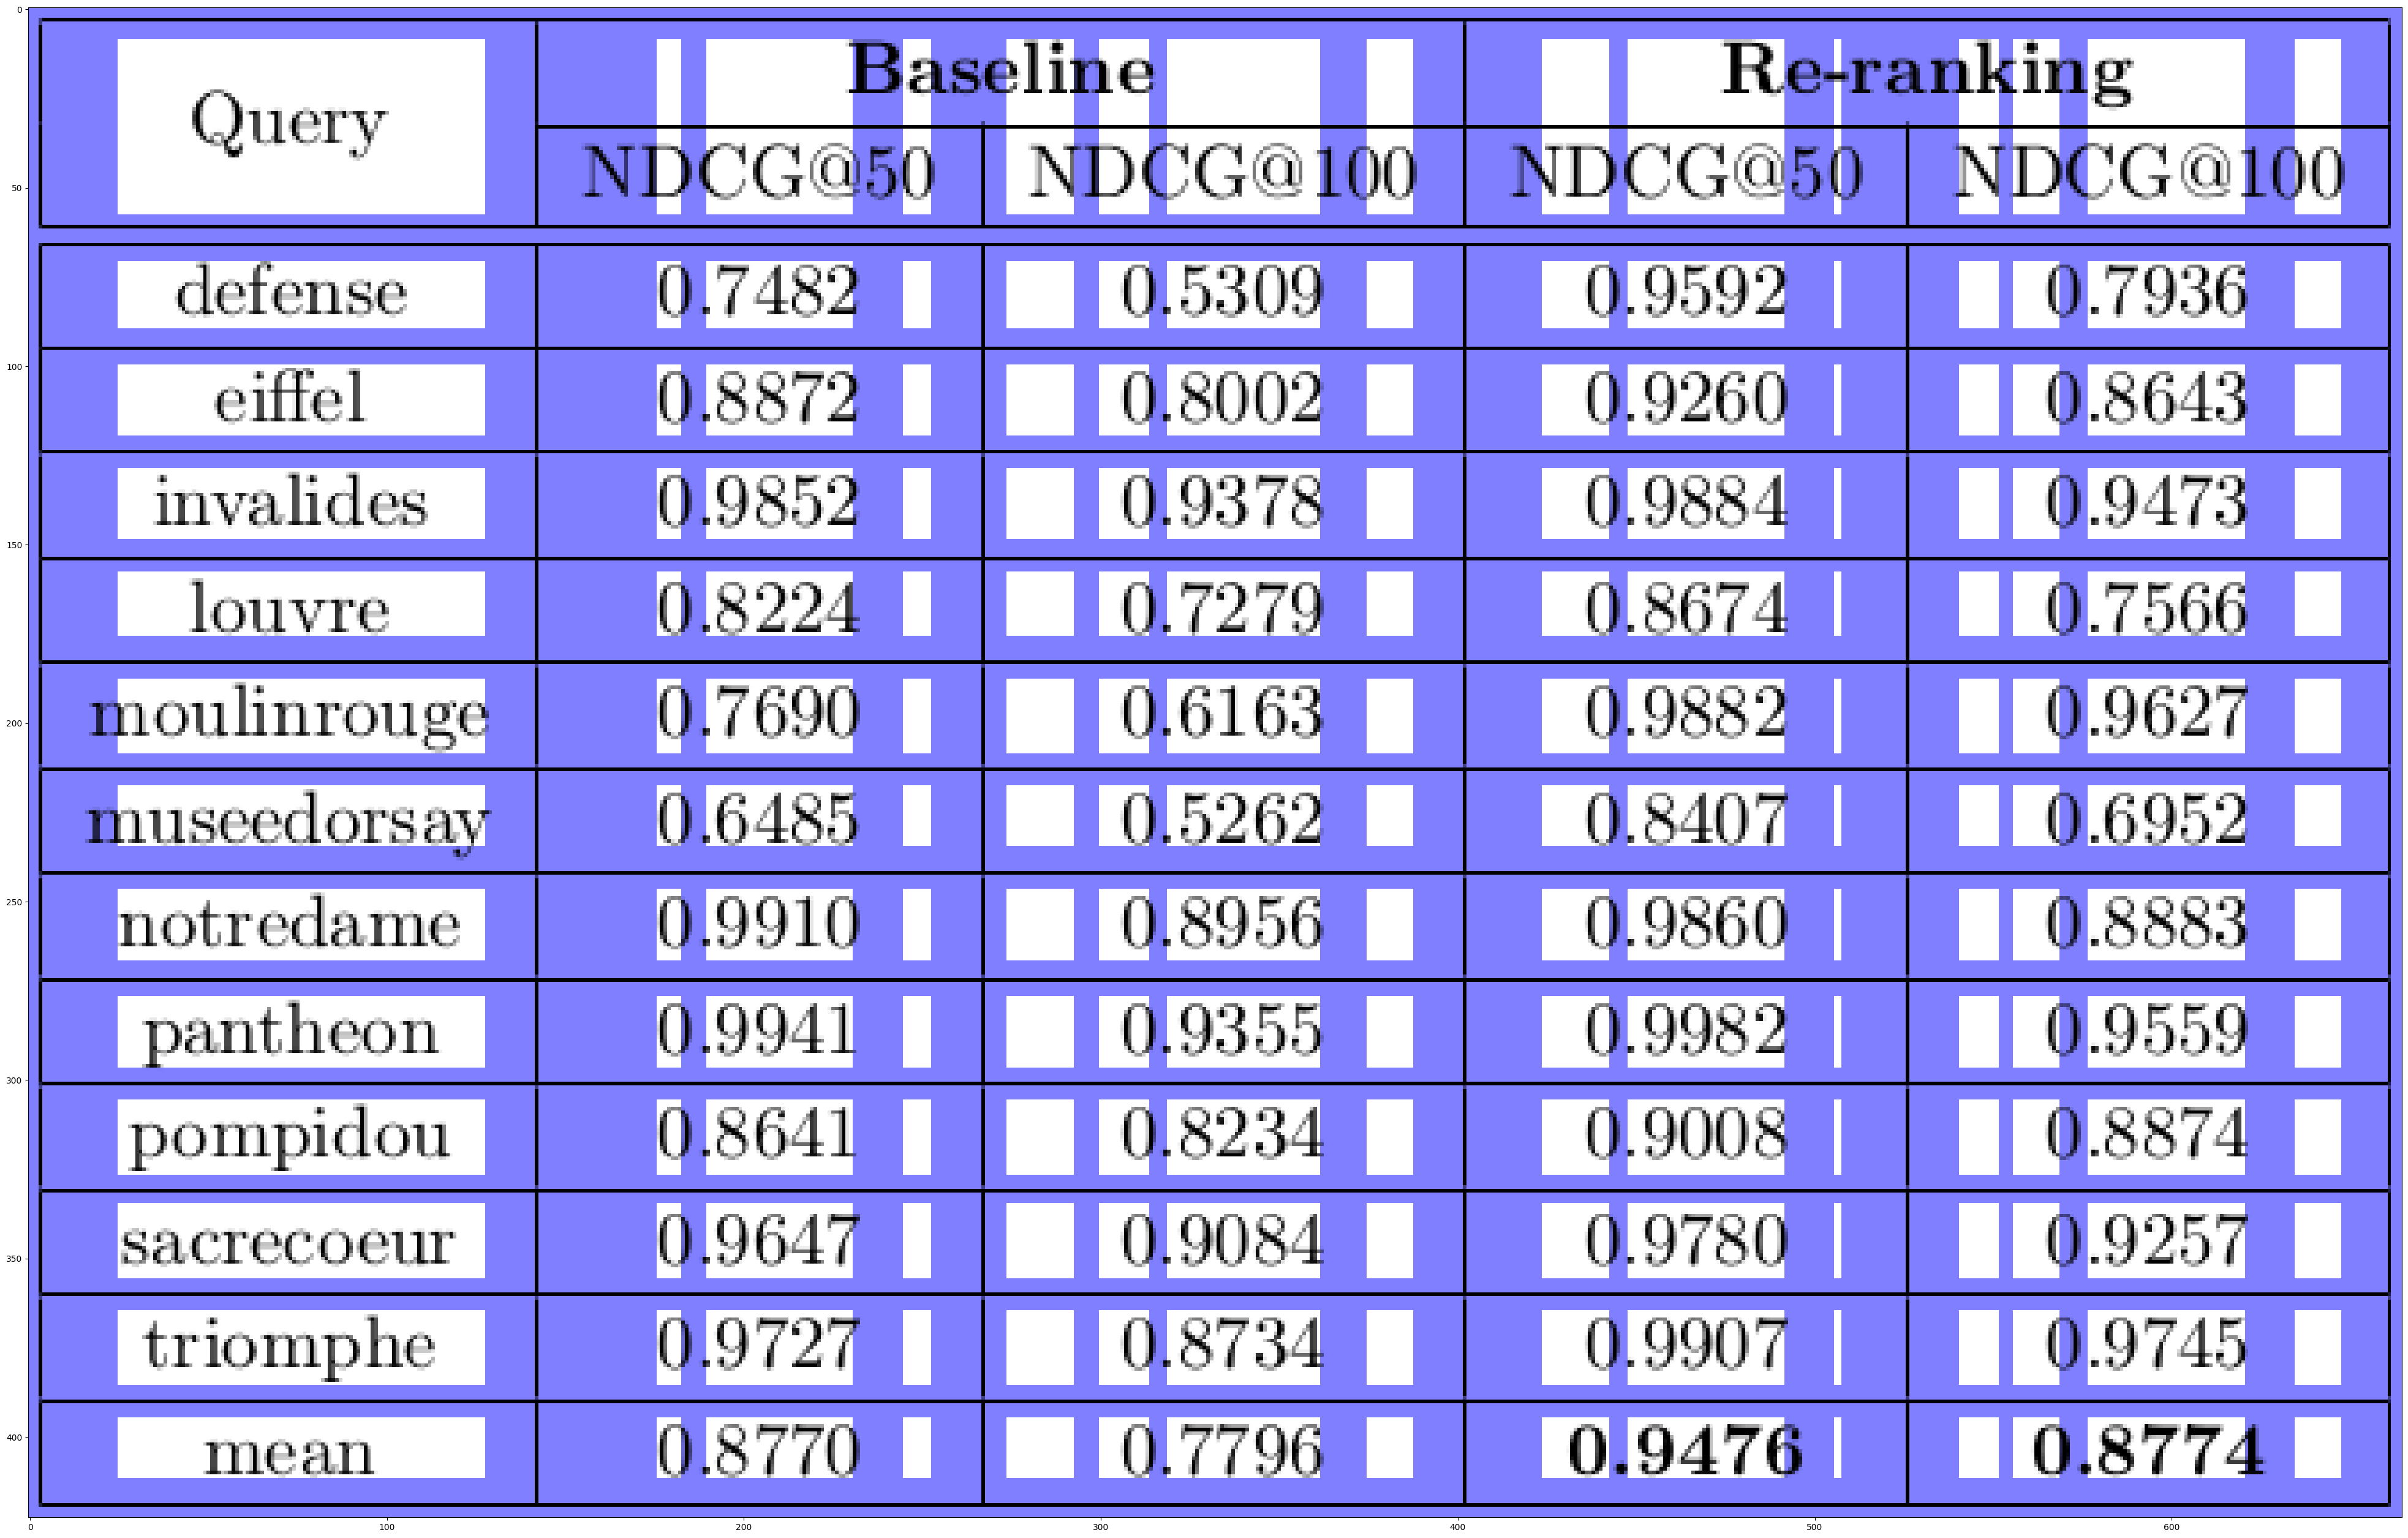

In [24]:
img_ready = prep_image(sample_img)

with torch.no_grad():
    r_pred, c_pred = model(img_ready)
r_pred, c_pred = process_split_results(r_pred, c_pred)
r_pred, c_pred = refine_split_results(r_pred), refine_split_results(c_pred)
vis_split(sample_img, r_pred, c_pred);

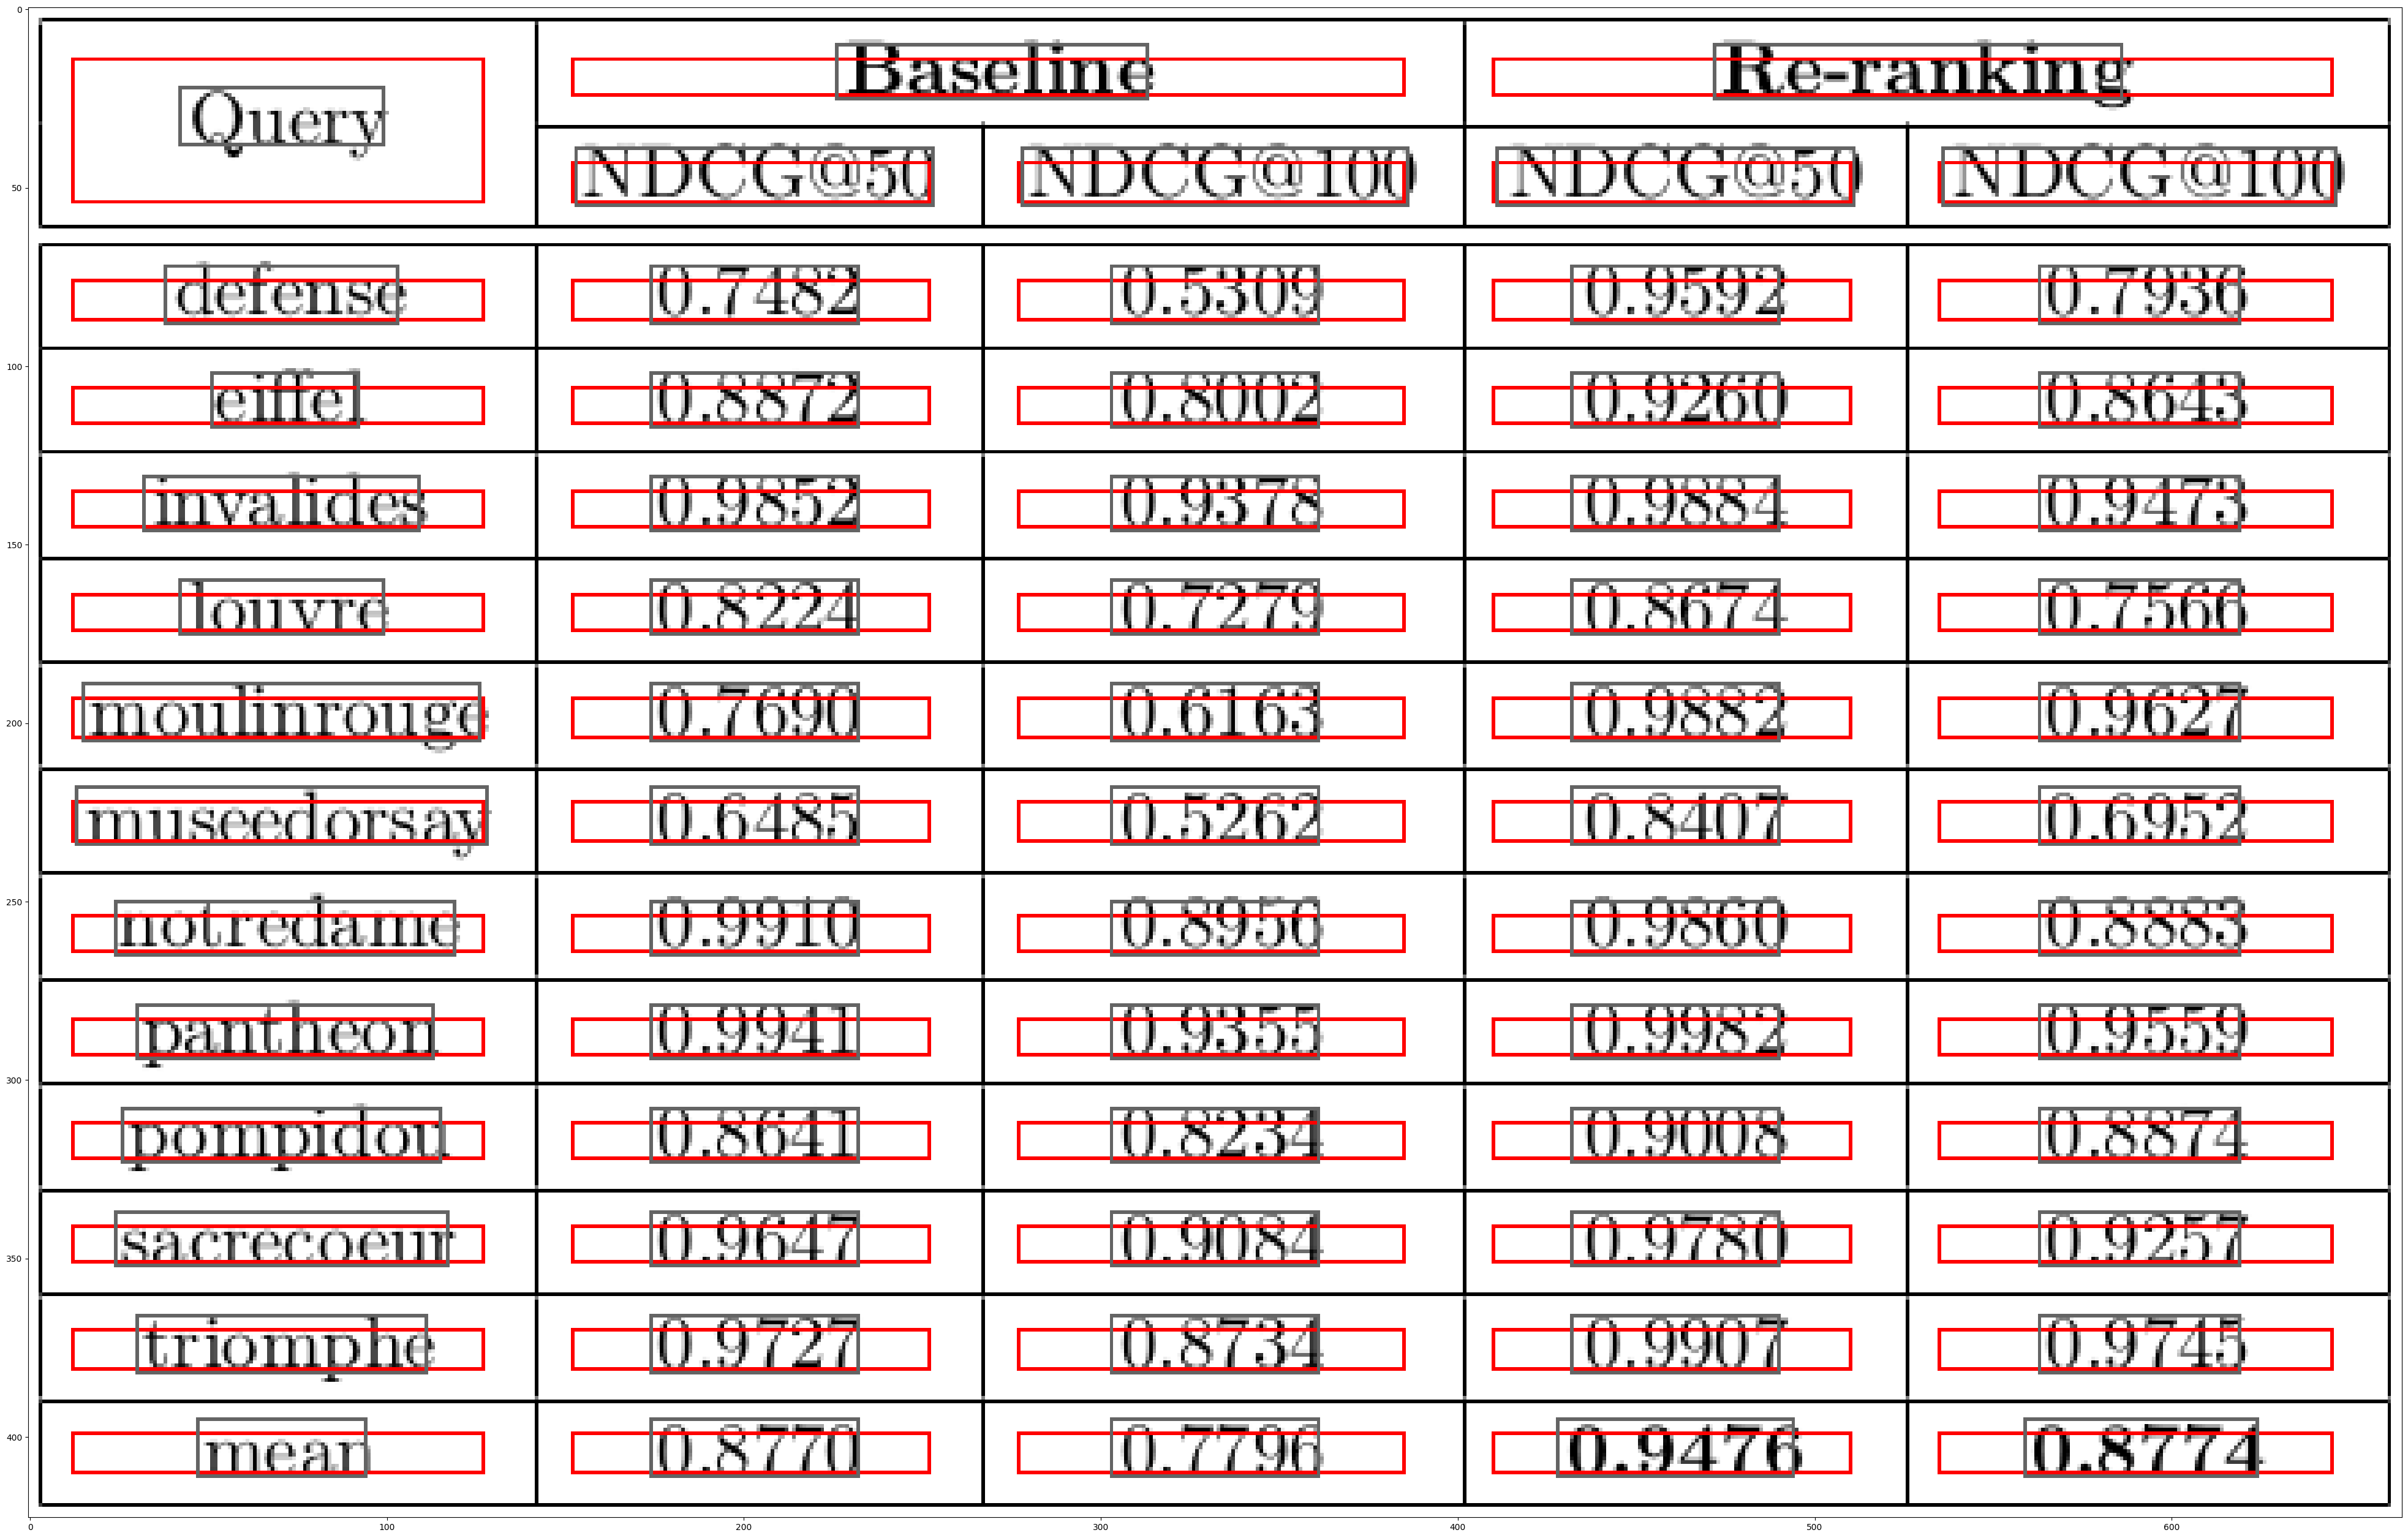

In [25]:
r_gt, c_gt, R_gt, D_gt = load_merge_gt(merge_labels, img_name)
row_gt_idxs, col_gt_idxs = borders(r_gt), borders(c_gt)
cells_gt = get_cells(row_gt_idxs, col_gt_idxs)
cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt, verbose=False)

texts_pos = chunk_labels[img_name]
img_gt = vis_cells(sample_img, cells_merged_gt, 'red')
img_gt = vis_chunks(img_gt, texts_pos)
view_imgs([img_gt])

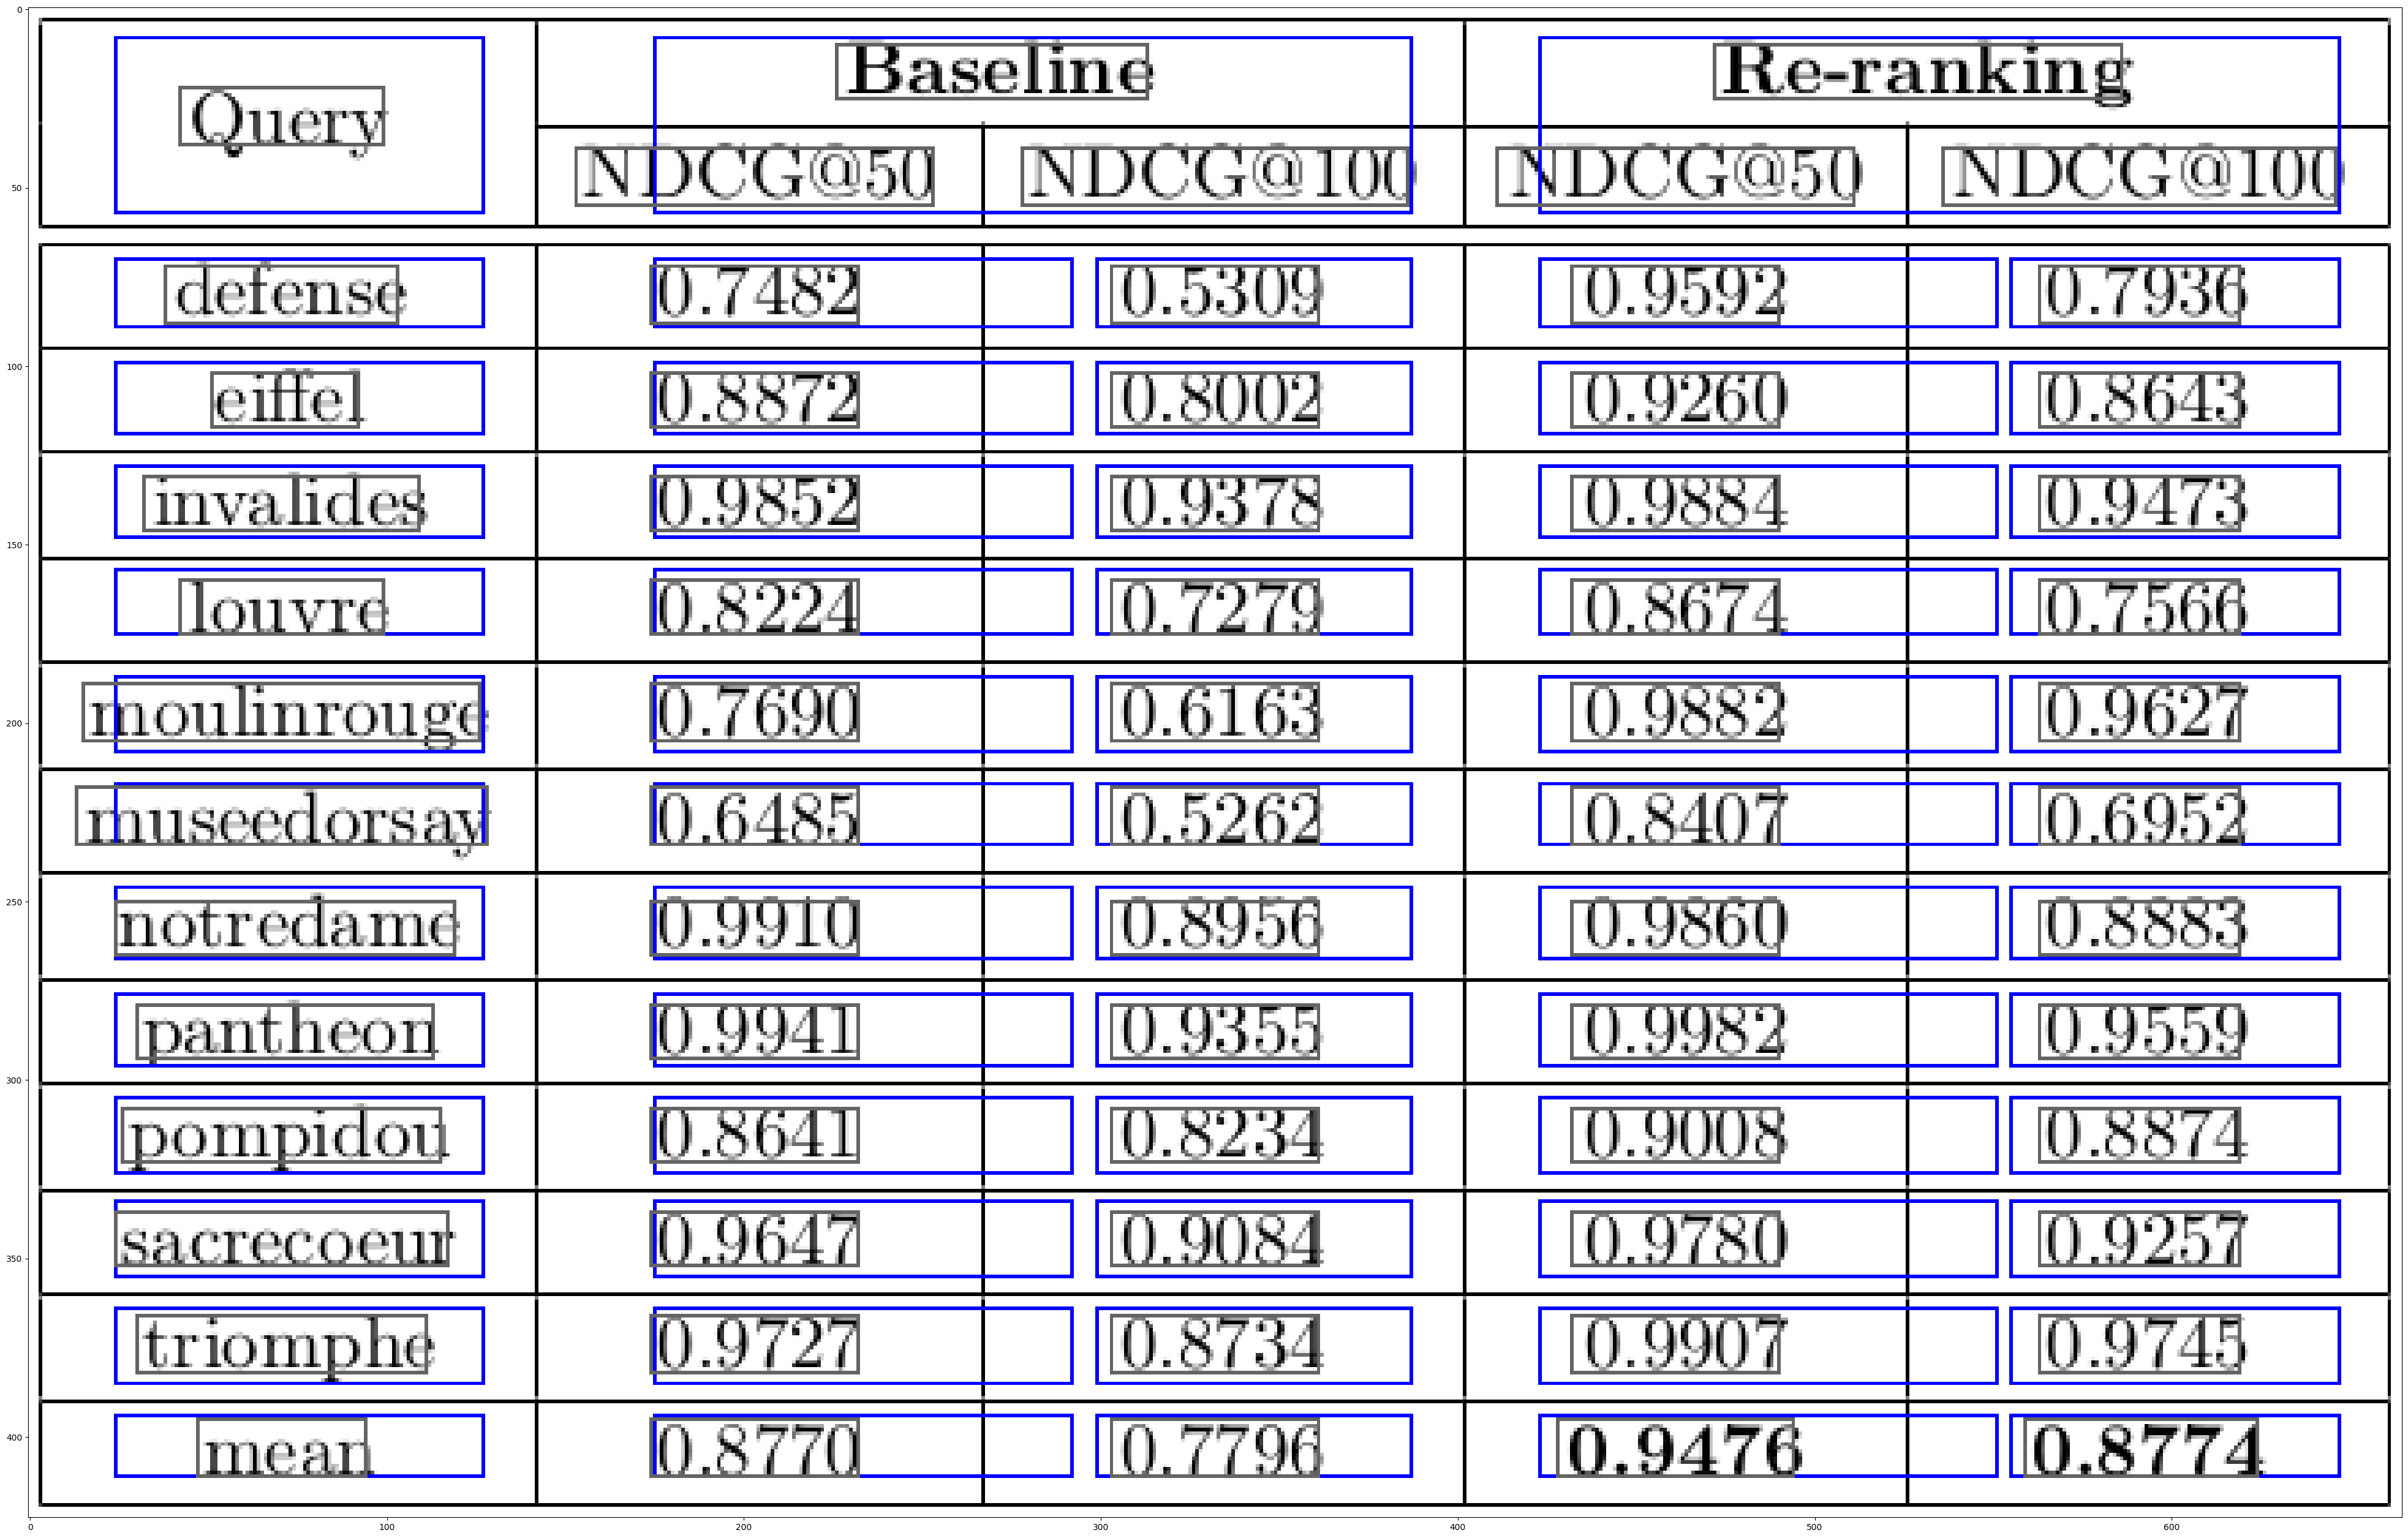

In [26]:
row_pred_idxs, col_pred_idxs = borders(r_pred), borders(c_pred)
cells_pred = get_cells(row_pred_idxs, col_pred_idxs)

# merge heuristics
texts_pos = chunk_labels[img_name]
R_pred, D_pred = create_pred_matrices(row_pred_idxs, col_pred_idxs)
rule1(cells_pred, texts_pos, R_pred, D_pred)
rule2(cells_pred, texts_pos, R_pred, D_pred)
rule3(cells_pred, texts_pos, R_pred)

# rule6(cells_pred, texts_pos, R_pred, D_pred)
cells_merged_pred = merge_cells(cells_pred, R_pred, D_pred, verbose=False)

img_pred = vis_cells(sample_img, cells_merged_pred)
img_pred = vis_chunks(img_pred, texts_pos)
view_imgs([img_pred])
